In [349]:
import pandas as pd
import numpy as np

# Depuración de steam_games
- En una primera instancia se hace foco en los campos que se necesitarán para el desarrollo de las Funciones. lista_columnas = ['genres', 'release_date', 'price', 'item_id', 'developer']
- No se eliminan los datos nulos en cada columna si hay datos en las demás.
- Se crea un archivo "depurado" para ser consumido por la API.
- Se podría intentar realizar un scraping de la información necesaria para mejorar el dataset (sólo si se llega a terminar el trabajo).

In [350]:
# Levanto los datos
df_steam_games = pd.read_parquet('..\\datasets\\1. Extracción\\steam_games.parquet')

In [351]:
# Observamos info del dataset
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   publisher     24083 non-null   object
 1   genres        28852 non-null   object
 2   app_name      32133 non-null   object
 3   title         30085 non-null   object
 4   url           32135 non-null   object
 5   release_date  30068 non-null   object
 6   tags          31972 non-null   object
 7   reviews_url   32133 non-null   object
 8   specs         31465 non-null   object
 9   price         120445 non-null  object
 10  early_access  32135 non-null   object
 11  id            32133 non-null   object
 12  developer     28836 non-null   object
dtypes: object(13)
memory usage: 11.9+ MB


- Análisis de la columna 'price'. Como "price" contiene texto y números al momento de la carga de datos, fue necesario guardarlo como "string" en el archivo parquet.
- Se analizan cuáles son los valores que "no son precios".

In [352]:
# Convierto 'price' en texto para asegurarnos que se puede manipular correctamente
df_steam_games['price'] = df_steam_games['price'].astype(str)

# Filtro valores que NO pueden ser convertidos a número (es decir, son texto) y cuento
df_steam_games[~df_steam_games['price'].str.replace('.', '', 1).str.isnumeric()]['price'].value_counts()

price
nan                              89687
Free                               905
Free to Play                       520
Free To Play                       462
Free Mod                             4
Free Demo                            3
Play for Free!                       2
Third-party                          2
Play Now                             2
Starting at $499.00                  1
Free Movie                           1
Free to Try                          1
Starting at $449.00                  1
Install Theme                        1
Play the Demo                        1
Free HITMAN™ Holiday Pack            1
Play WARMACHINE: Tactics Demo        1
Install Now                          1
Free to Use                          1
Name: count, dtype: int64

- Como resultado se observa:
    - "nan": son valores nulos, se tratarán como nulos al momento de transformar "price" en valor numérico nuevamente.
    - La gran mayoría contienen la palabra "Free". 
    - Modificamos valores específicos (449 y 499).
    - Se toman los que no son "nan" y no son número y se le asigna valor "0" USD. 
    - Se crea una columna "Free" = True or False para un mejor funcionamiento de la API. Free = True son aquelos que valen "0" USD

In [353]:
# Reemplazo valores específicos
df_steam_games['price'] = df_steam_games['price'].replace('Starting at $499.00', '499')
df_steam_games['price'] = df_steam_games['price'].replace('Starting at $449.00', '449')

# Reemplazo los demás valores texto por $0, excepto los "nan"
df_steam_games['price'] = df_steam_games['price'].apply( lambda x: 0 if (x != 'nan' and not x.replace('.', '', 1).isnumeric()) else x)

# Convierto la colmna "price" a tipo float y los "nan" a "NaN"
df_steam_games['price'] = pd.to_numeric(df_steam_games['price'], errors='coerce')

# Creo la columna 'Free', donde si el precio es 0 la columna es "True" - Servirá para análisis posteriores.
df_steam_games['free'] = df_steam_games['price'].apply(lambda x: True if x == 0 else False)

#Verifico que la cantidad de "Free" coincida con la cantidad calculada anterior (sin contar los dos "starting" y los nan)
cantidad_free = df_steam_games['free'].sum()
print(cantidad_free)

1908


- Se realizan las siguientes modificaciones adicionales:
    - Se reemplazan valores "None" por nulos de numpy
    - Se descartan todas las filas que tengan todos los campos Nulos.
    - Se modifica el formato del campo fecha como DateTime.
    - Se crea una columna con el año que se va a requerir en la API.

In [354]:
# Reemplazo None por np.nan 
df_steam_games = df_steam_games.replace({None: np.nan})

# Elilmino filas donde TODOS los valores son nulos: si todos los valores de la fila son nulos los puedo descartar seguro.
df_steam_games = df_steam_games.dropna(how='all')

# Modifico el formato de 'release_date' para poder usarlo como fecha.
df_steam_games['release_date'] = pd.to_datetime(df_steam_games['release_date'], errors='coerce')

# Creo la columna con el año de 'release_date' que se necesita en la función "developer"
df_steam_games['year'] = df_steam_games['release_date'].dt.year


- Tratamiento de columna id:
    - Se renombra el campo id para que coincida con la tabla de users_items. 
    - Se cuentan los nulos, y se decide eliminarlos.  (Podría cruzarlo a partir del app_name con item_name del archivo de users_items (para una instancia posterior))
    - Se eliminan todas las filas que tengan un nulo en el iitem_id
    - Se transforma a Integer

In [355]:
# Renombro id a item_id para que coincida con el dataseet de users_items
df_steam_games = df_steam_games.rename(columns={'id': 'item_id'})

In [356]:
# Cuento los valores nulos en id. Estas líneas no sirven si no puedo identificar el id del item.
print(df_steam_games['item_id'].isnull().sum())


88312


In [357]:
# Elimino filas donde item_id es nulo
df_steam_games = df_steam_games.dropna(subset=['item_id'])

In [358]:
# Verifico que todos los item_id son números.
df_steam_games[~df_steam_games['item_id'].str.isnumeric()]['item_id'].value_counts()

Series([], Name: count, dtype: int64)

In [359]:
# Convierto la colmna "item_id" a int 
df_steam_games['item_id'] = df_steam_games['item_id'].astype('Int64')

In [360]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32133 entries, 88310 to 120444
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     24082 non-null  object        
 1   genres        28851 non-null  object        
 2   app_name      32132 non-null  object        
 3   title         30084 non-null  object        
 4   url           32133 non-null  object        
 5   release_date  29782 non-null  datetime64[ns]
 6   tags          31971 non-null  object        
 7   reviews_url   32133 non-null  object        
 8   specs         31464 non-null  object        
 9   price         30756 non-null  float64       
 10  early_access  32133 non-null  object        
 11  item_id       32133 non-null  Int64         
 12  developer     28835 non-null  object        
 13  free          32133 non-null  bool          
 14  year          29782 non-null  float64       
dtypes: Int64(1), bool(1), datetime64[ns]

- Análisis de duplicados:
    - Se cuentan la cantidad de filas duplicadas consderando en una primera instancia sólo las columnas necesarias en la API, y luego considerando todas aquellas que no tienen un Array dentro.

In [361]:
# Contar la cantidad de líneas duplicadas - Considero las columnas que voy a utilziar en la API menos la de "genres" que tiene un Array dentro.
duplicated_count = df_steam_games.duplicated(subset = ['release_date', 'price', 'item_id', 'developer','year','free']).sum()
print(duplicated_count )

1


In [362]:
# Filtrar las líneas duplicadas
duplicated_rows = df_steam_games[df_steam_games.duplicated(subset=['release_date', 'price', 'item_id', 'developer', 'year', 'free'], keep=False)]
duplicated_rows.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year
102204,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,False,2017.0
102883,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,False,2017.0


In [363]:
# Elimino duplicados en base al subconjunto de columnas
df_steam_games_cleaned = df_steam_games.drop_duplicates(subset=['release_date', 'price', 'item_id', 'developer', 'year', 'free'], keep='first')

In [364]:
# Observamos resultado
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32133 entries, 88310 to 120444
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     24082 non-null  object        
 1   genres        28851 non-null  object        
 2   app_name      32132 non-null  object        
 3   title         30084 non-null  object        
 4   url           32133 non-null  object        
 5   release_date  29782 non-null  datetime64[ns]
 6   tags          31971 non-null  object        
 7   reviews_url   32133 non-null  object        
 8   specs         31464 non-null  object        
 9   price         30756 non-null  float64       
 10  early_access  32133 non-null  object        
 11  item_id       32133 non-null  Int64         
 12  developer     28835 non-null  object        
 13  free          32133 non-null  bool          
 14  year          29782 non-null  float64       
dtypes: Int64(1), bool(1), datetime64[ns]

In [365]:
# Contar la cantidad de líneas duplicadas - Considero todas las columnas menos las que tienen Arrays dentro
duplicated_count = df_steam_games.duplicated(subset=df_steam_games.columns.difference(['genres','specs','tags'])).sum()
print(duplicated_count )

0


- Se analiza la columna developer para unificar valores distintos:
    - La desnormalización del developer es muy grande.
    - Si hay tiempo se intentará scrapear este dato nuevamente. 

In [372]:
# Transforo la columna 'developer' al tipo oración y elimino espacios extra
df_steam_games['developer'] = df_steam_games['developer'].fillna('').astype(str).str.capitalize().str.strip()

# Valores únicos ordenados alfabéticamente
sorted_developers = sorted(df_steam_games['developer'].unique())

# Los exporto para analizarlos en csv.
df_sorted_developers = pd.DataFrame(sorted_developers, columns=['developer'])
df_sorted_developers.to_csv('sorted_developers.csv', index=False)


- Se analizan outliers de price y de release_date.

In [311]:
print(df_steam_games.describe())

                        release_date         price        item_id  \
count                          29782  30756.000000        32133.0   
mean   2015-04-21 10:49:09.916056832      8.896955  451757.412909   
min              1970-07-15 00:00:00      0.000000           10.0   
25%              2014-10-01 00:00:00      2.990000       329280.0   
50%              2016-04-18 00:00:00      4.990000       452060.0   
75%              2017-04-17 00:00:00      9.990000       593400.0   
max              2021-12-31 00:00:00    995.000000      2028850.0   
std                              NaN     16.341118  182714.045546   

               year  
count  29782.000000  
mean    2014.759251  
min     1970.000000  
25%     2014.000000  
50%     2016.000000  
75%     2017.000000  
max     2021.000000  
std        3.508234  


- "release_date" tiene fechas razonables. Se presentaron dudas sobre la fecha más vieja, 15/07/1970, pero se verifica en la web.

<img src="../_src/Juego_Más_Viejo.PNG" height="300"><br>

In [312]:
df_steam_games[df_steam_games['release_date'] == df_steam_games['release_date'].min()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year
103157,NaN,NaN,Last Train To Berlin,Last Train To Berlin,http://store.steampowered.com/app/734030/Last_...,1970-07-15,[Movie],http://steamcommunity.com/app/734030/reviews/?...,[Captions available],3.99,False,734030,NaN,False,1970.0


- "price": si bien la media es baja, los valores extremos no parecieran estar errados, es razonable que un juego pueda valer 995 USD.

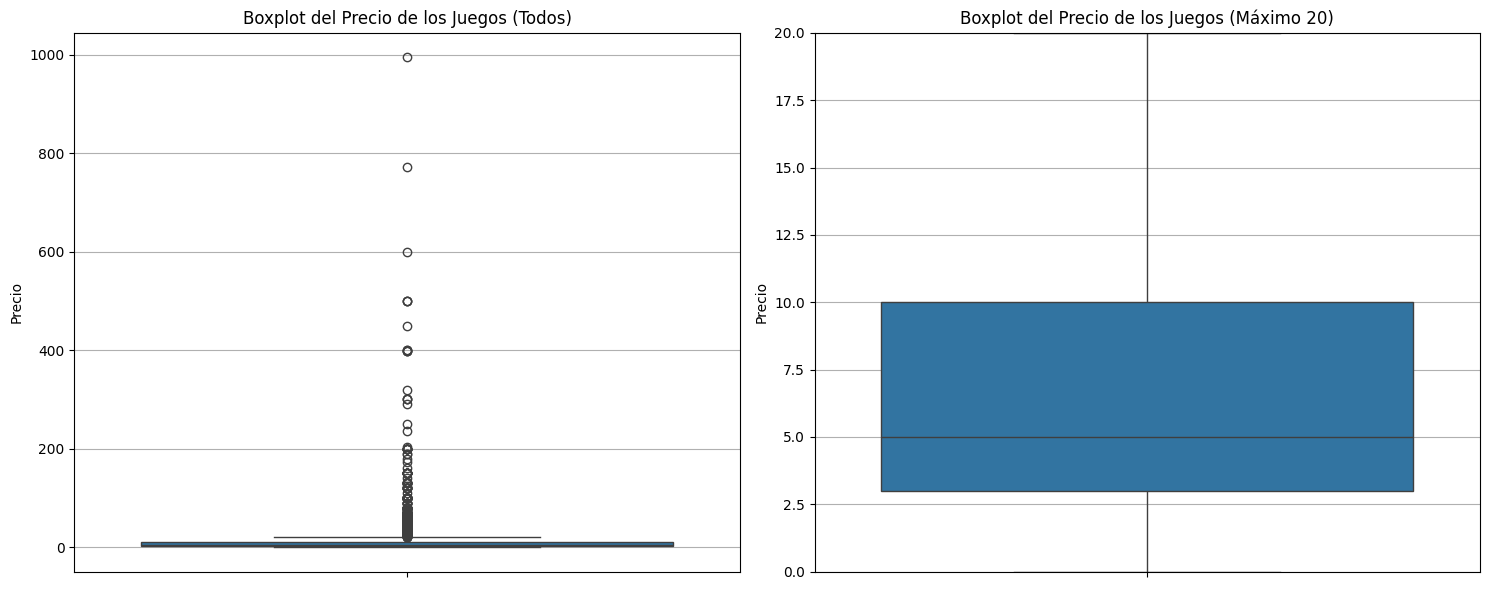

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creo un boxplot para la columna 'price' usando seaborn
# Creo la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Primer boxplot con todos los precios
sns.boxplot(y=df_steam_games['price'], ax=axes[0])
axes[0].set_title('Boxplot del Precio de los Juegos (Todos)')
axes[0].set_ylabel('Precio')
axes[0].grid(axis='y')

# Segundo boxplot recortado a un precio máximo de 20
sns.boxplot(y=df_steam_games['price'], ax=axes[1])
axes[1].set_title('Boxplot del Precio de los Juegos (Máximo 20)')
axes[1].set_ylabel('Precio')
axes[1].grid(axis='y')
axes[1].set_ylim(0, 20)


# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [314]:
# Guardo el DF depurado con todas las columnas.
df_steam_games.to_parquet('..\\datasets\\2. Depurado\\steam_games_depurado.parquet', index=False)

# # Me quedo con las columnas que voy a usar en la API: genres, released_date, price, item_id  y developer
# lista_columnas = ['genres', 'release_date', 'price', 'item_id', 'developer','year','free']
# df_steam_games = df_steam_games[lista_columnas]

# # Guardo el DF para levantarlo con la API.
# df_steam_games.to_parquet('..\\datasets\\3. Depurado y Reducido\\steam_games_dep_reducido.parquet', index=False)

---
# Depuración de users_reviews

In [315]:
# #Levanto los datos
df_reviews = pd.read_parquet('..\\datasets\\1. Extracción\\user_reviews.parquet')

In [316]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59333 non-null  object
 1   user_url   59333 non-null  object
 2   item_id    59305 non-null  object
 3   posted     59305 non-null  object
 4   helpful    59305 non-null  object
 5   recommend  59305 non-null  object
 6   funny      59305 non-null  object
 7   review     59305 non-null  object
dtypes: object(8)
memory usage: 3.6+ MB


- Se realiza el análisis de nulos de forma similar an el dataset anterior.

In [317]:
# Cuento los valores nulos en user_id. 
print(df_reviews['user_id'].isnull().sum())

0


In [318]:
# Cuento los valores nulos en item_id. 
print(df_reviews['item_id'].isnull().sum())

28


In [319]:
# Elimino filas donde item_id es nulo ya que no me sirve para relacionarlo con otras tablas.
df_reviews = df_reviews.dropna(subset=['item_id'])

In [320]:
# Verifico que todos los item_id son números.
df_reviews[~df_reviews['item_id'].str.isnumeric()]['item_id'].value_counts()

Series([], Name: count, dtype: int64)

In [321]:
# Convierto la colmna "item_id" a int 
df_reviews['item_id'] = df_reviews['item_id'].astype('Int64')

- Análisis de duplicados:

In [322]:
# Cuento la cantidad de líneas duplicadas - No cuenta la primera aparición.
duplicated_count = df_reviews.duplicated().sum()

# Cuento la cantidad de líneas duplicadas (contando todas las apariciones)
total_duplicated_count = df_reviews.duplicated(keep=False).sum()

# Cuento la cantidad de veces que ocurre la relación de cada combinación user_id - item_id
repeated_relationships = df_reviews.groupby(['user_id', 'item_id']).size().reset_index(name='count')

# Filtro las relaciones que se repiten
repeated_relationships = repeated_relationships[repeated_relationships['count'] > 1]

# Sumo las duplicaciones
count_repeated_relationships = repeated_relationships[['count']].sum()

# Muestro los resultados
print(f'Cantidad de líneas duplicadas (no cuenta la primera aparición): {duplicated_count}')
print(f'Cantidad de líneas duplicadas (contamos todas las apariciones): {total_duplicated_count}')
print(f'Cantidad de relaciones user_id - item_id repetidas: {repeated_relationships.shape[0]}')
print(f'Suma de las repeticiones mayores a 1: {count_repeated_relationships}')


Cantidad de líneas duplicadas (no cuenta la primera aparición): 874
Cantidad de líneas duplicadas (contamos todas las apariciones): 1736
Cantidad de relaciones user_id - item_id repetidas: 862
Suma de las repeticiones mayores a 1: count    1736
dtype: int64


In [323]:
# Visualizo las relaciones que se repiten
repeated_relationships[repeated_relationships['count'] > 1]

,user_id,item_id,count
91,05041129,440,2
92,05041129,730,2
93,05041129,277430,2
184,111222333444555666888,730,2
185,111222333444555666888,8870,2
...,...,...,...
57757,xXAussieRockXx,220240,2
57758,xXAussieRockXx,304050,2
58019,yolofaceguy,250320,2
58020,yolofaceguy,261030,2


In [324]:
# Verifico con un ejemplo
filtered_reviews = df_reviews[(df_reviews["user_id"] == "05041129") & (df_reviews["item_id"] == 277430) ]

# Mostrar el DataFrame filtrado
filtered_reviews.head()

,user_id,user_url,item_id,posted,helpful,recommend,funny,review
13415,05041129,http://steamcommunity.com/id/05041129,277430,"Posted January 5, 2015.",1 of 1 people (100%) found this review helpful,True,1 person found this review funny,this is the best third person game ever that i...
32000,05041129,http://steamcommunity.com/id/05041129,277430,"Posted January 5, 2015.",1 of 1 people (100%) found this review helpful,True,1 person found this review funny,this is the best third person game ever that i...


In [325]:
# Verifico con un ejemplo
filtered_reviews = df_reviews[(df_reviews["user_id"] == "xXAussieRockXx") & (df_reviews["item_id"] == 220240) ]

# Mostrar el DataFrame filtrado
filtered_reviews.head()

,user_id,user_url,item_id,posted,helpful,recommend,funny,review
6858,xXAussieRockXx,http://steamcommunity.com/id/xXAussieRockXx,220240,"Posted December 8, 2014.",No ratings yet,True,,Far Cry 3 is by far right now one of my favour...
21449,xXAussieRockXx,http://steamcommunity.com/id/xXAussieRockXx,220240,"Posted December 8, 2014.",No ratings yet,True,,Far Cry 3 is by far right now one of my favour...


- Elimino las filas duplicadas

In [326]:
df_reviews.drop_duplicates(inplace=True)

In [327]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 58431 entries, 0 to 59332
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58431 non-null  object
 1   user_url   58431 non-null  object
 2   item_id    58431 non-null  Int64 
 3   posted     58431 non-null  object
 4   helpful    58431 non-null  object
 5   recommend  58431 non-null  object
 6   funny      58431 non-null  object
 7   review     58431 non-null  object
dtypes: Int64(1), object(7)
memory usage: 4.1+ MB
None


In [328]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 58431 entries, 0 to 59332
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58431 non-null  object
 1   user_url   58431 non-null  object
 2   item_id    58431 non-null  Int64 
 3   posted     58431 non-null  object
 4   helpful    58431 non-null  object
 5   recommend  58431 non-null  object
 6   funny      58431 non-null  object
 7   review     58431 non-null  object
dtypes: Int64(1), object(7)
memory usage: 4.1+ MB
None


In [329]:
# Guardo el DF depurado.
df_reviews.to_parquet('..\\datasets\\2. Depurado\\user_reviews_depurado.parquet', index=False)

---
# Depuración de users_items

In [330]:
# #Levanto los datos
df_user_items = pd.read_parquet('..\\datasets\\1. Extracción\\users_items.parquet')

In [331]:
df_user_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   user_url          object 
 2   item_id           object 
 3   item_name         object 
 4   playtime_forever  float64
 5   playtime_2weeks   float64
dtypes: float64(2), object(4)
memory usage: 236.7+ MB


- Análisis de nulos de forma similar a las anteriores.

In [332]:
# Cuento las que no nulos
print(df_user_items.notnull().sum())

user_id             5170015
user_url            5170015
item_id             5153209
item_name           5153209
playtime_forever    5153209
playtime_2weeks     5153209
dtype: int64


In [333]:
# Cuento las que tienen nulos
print(df_user_items.isnull().sum())

user_id                 0
user_url                0
item_id             16806
item_name           16806
playtime_forever    16806
playtime_2weeks     16806
dtype: int64


- Se eliminan las filas que no tienen "item_id" ya que no existe la relación user_id - item_id.

In [334]:
# Eliminar filas donde item_id es nulo
df_user_items = df_user_items.dropna(subset=['item_id'])

In [335]:
# Cuento las que tienen nulos
print(df_user_items.isnull().sum())

user_id             0
user_url            0
item_id             0
item_name           0
playtime_forever    0
playtime_2weeks     0
dtype: int64


In [336]:
# Convierto la colmna "item_id" a int 
df_user_items['item_id'] = df_user_items['item_id'].astype('Int64')

In [337]:
# Reemplazo None por np.nan 
df_user_items = df_user_items.replace({None: np.nan})

- Análisis de duplicados:
    - En este caso se presentó la condición de tener relaciones user_id - item_id repetidas pero en cuyas filas no todas las columnas tienen el mismo valor.

In [338]:
# Cuento la cantidad de líneas duplicadas
df_user_items.duplicated().sum()

59104

In [339]:
# Cuento la cantidad de líneas duplicadas - No cuenta la primera aparición.
duplicated_count = df_user_items.duplicated().sum()

# Cuento la cantidad de líneas duplicadas (contando todas las apariciones)
total_duplicated_count = df_user_items.duplicated(keep=False).sum()

# Cuento la cantidad de veces que ocurre la relación de cada combinación user_id - item_id
repeated_relationships = df_user_items.groupby(['user_id', 'item_id']).size().reset_index(name='count')

# Filtro las relaciones que se repiten
repeated_relationships = repeated_relationships[repeated_relationships['count'] > 1]

# Sumo las duplicaciones
count_repeated_relationships = repeated_relationships[['count']].sum()

# Muestro los resultados
print(f'Cantidad de líneas duplicadas (no cuenta la primera aparición): {duplicated_count}')
print(f'Cantidad de líneas duplicadas (contamos todas las apariciones): {total_duplicated_count}')
print(f'Cantidad de relaciones user_id - item_id repetidas: {repeated_relationships.shape[0]}')
print(f'Suma de las repeticiones mayores a 1: {count_repeated_relationships}')

Cantidad de líneas duplicadas (no cuenta la primera aparición): 59104
Cantidad de líneas duplicadas (contamos todas las apariciones): 117731
Cantidad de relaciones user_id - item_id repetidas: 58647
Suma de las repeticiones mayores a 1: count    117774
dtype: int64


- Se identifican las relaciones user_id - item_id que NO tienen los mismos datos en todas las columnas. Se analizan estas relaciones.

In [340]:
# Agrupo por relación y me quedo con las repetidas (count > 1)
repeated_combinations = df_user_items.groupby(['user_id', 'item_id']).size().reset_index(name='count')
repeated_combinations = repeated_combinations[repeated_combinations['count'] > 1]

# Filtro las combinaciones repetidas en el dataframe original
df_repeated_rows = df_user_items.merge(repeated_combinations[['user_id', 'item_id']], on=['user_id', 'item_id'])

# Descarto todas filas donde los datos en TODAS las columnas no son iguales
df_different_rows = df_repeated_rows.drop_duplicates()

# Agrupo por user_id e item_id nuevamente y contar cuántas variaciones hay
df_varied_relationships = df_different_rows.groupby(['user_id', 'item_id']).size().reset_index(name='variations')
df_varied_relationships = df_varied_relationships[df_varied_relationships['variations'] > 1]
df_varied_relationships

,user_id,item_id,variations
11052,76561198050680344,377160,2
14808,76561198064484479,232090,2
15009,76561198064956087,40100,2
17383,76561198072861800,433850,3
18951,76561198079079942,282070,2
19219,76561198080450686,730,2
19237,76561198080450686,252950,2
19248,76561198081666970,730,2
19289,76561198081666970,361600,2
31071,Jojibu,460870,2


In [341]:
# Verifico con un ejemplo
filtered_reviews = df_user_items[(df_user_items["user_id"] == "sergioxks1") & (df_user_items["item_id"] == 291410)]

# Mostrar el DataFrame filtrado
filtered_reviews.head()

,user_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
1528382,sergioxks1,http://steamcommunity.com/id/sergioxks1,291410,Duelyst,1357.0,1113.0
3371879,sergioxks1,http://steamcommunity.com/id/sergioxks1,291410,Duelyst,1371.0,1128.0


In [342]:
df_user_items[(df_user_items["user_id"] == "chocolatemanj")] 

,user_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
236905,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,240,Counter-Strike: Source,1732.0,0.0
236906,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,205790,Dota 2 Test,0.0,0.0
236907,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,730,Counter-Strike: Global Offensive,65204.0,757.0
236908,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,202970,Call of Duty: Black Ops II,1.0,0.0
236909,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,202990,Call of Duty: Black Ops II - Multiplayer,320.0,0.0
236910,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,212910,Call of Duty: Black Ops II - Zombies,10.0,0.0
236911,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,202090,Magicka: Wizard Wars,812.0,0.0
236912,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,239220,The Mighty Quest For Epic Loot,511.0,0.0
236913,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,252490,Rust,3080.0,0.0
236914,chocolatemanj,http://steamcommunity.com/id/chocolatemanj,252950,Rocket League,68.0,0.0


- La mayoría de estos duplicados no se encuentran en Steam porque los usuarios están dados de baja o por perfil es privado. 
- Tomamos como criterio quedarnos con el que cumpla tener playtime_forever más elevado primero y si son iguales, playtime_2weeks más elevado.

In [343]:
# Ordeno por user_id, item_id, playtime_forever (descendente) y playtime_2weeks (descendente)
df_user_items.sort_values(by=['user_id', 'item_id', 'playtime_forever', 'playtime_2weeks'], ascending=[True, True, False, False], inplace=True)

# Elimino duplicados de user_id e item_id, quedandome con la primera aparición (que será la de mayor playtime)
df_user_items.drop_duplicates(subset=['user_id', 'item_id'], keep='first', inplace=True)

In [344]:
# Verifico con el mismo ejemplo anterior
filtered_reviews = df_user_items[(df_user_items["user_id"] == "sergioxks1") & (df_user_items["item_id"] == 291410)]

# Mostrar el DataFrame filtrado
filtered_reviews.head()

,user_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
3371879,sergioxks1,http://steamcommunity.com/id/sergioxks1,291410,Duelyst,1371.0,1128.0


In [345]:
# Cuento la cantidad de líneas duplicadas
df_user_items.duplicated().sum()

0

In [346]:
# Vuelvo a contar las que no nulos
print(df_user_items.notnull().sum())

user_id             5094082
user_url            5094082
item_id             5094082
item_name           5094082
playtime_forever    5094082
playtime_2weeks     5094082
dtype: int64


In [347]:
print(df_user_items.describe())

             item_id  playtime_forever  playtime_2weeks
count      5094082.0      5.094082e+06     5.094082e+06
mean    178391.45484      9.905071e+02     9.065419e+00
std    131851.395185      5.414098e+03     1.402840e+02
min             10.0      0.000000e+00     0.000000e+00
25%          34450.0      0.000000e+00     0.000000e+00
50%         214420.0      3.400000e+01     0.000000e+00
75%         266430.0      3.550000e+02     0.000000e+00
max         530720.0      6.427730e+05     1.996700e+04


In [348]:
# Guardo el DF en parquet para levantarlo más rápido la próxima vez.
df_user_items.to_parquet('..\\datasets\\2. Depurado\\users_items_depurado.parquet', index=False)